 # MNIST를 이용하여 Stable Diffusion 아키텍처 구현

라이브러리 임포트

In [22]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import math

import functools as functions

from tqdm import tqdm
from einops import rearrange



Stable Diffusion은 Diffusion, U-net, 오토인코더, 트랜스포머 어텐션 모델을 사용하여 텍스트 조건에서 이미지 생성을 가능하도록 함

+ VAE 오토인코더 : 입출력 데이터를 잠재공간차원에 매핑하여 계산 성능을 높임
+ 순방향 확산(foward diffusion) : 입력 이미지에서 점진적으로 노이즈 이미지로 계산, 학습용 데이터로 사용함
+ 역방향 확산(reverse difusion) : 노이즈에서 이미지를 생성하도록 함
+ U-net: 노이즈 예측에 사용
+ 컨디셔닝 : 텍스트에 따른 조건부 이미 생성에 사용, CLIP 모델과 같은 트랜스포머 어텐션 사용

MNIST 데이터셋을 불러오기

In [2]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset=torchvision.datasets.MNIST(root='../data',train=True,transform=transform,download=True)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)

불러온 데이터셋 이미지 확인

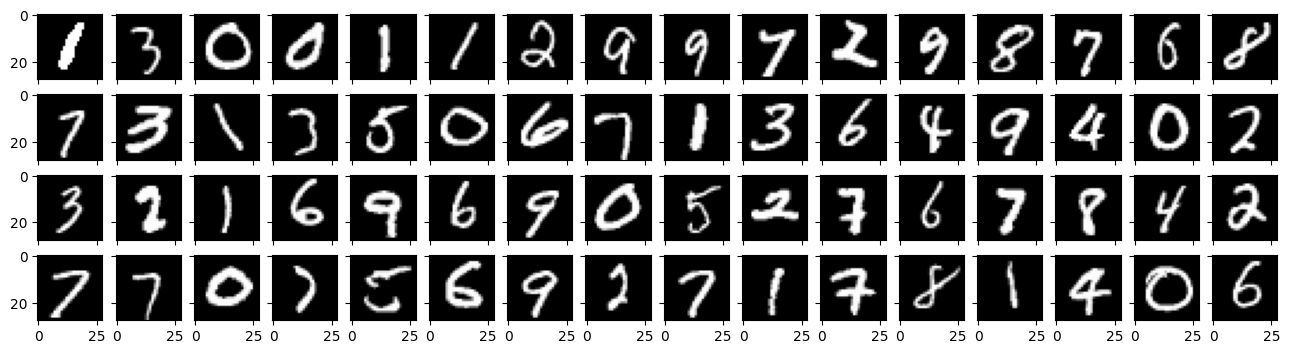

In [3]:
unique_images,unique_labels=next(iter(train_loader))
unique_images=unique_images.numpy()
row,column=4,16
fig,axes=plt.subplots(row,column,figsize=(16,4),sharex=True,sharey=True)
for i in range(row):
    for j in range(column):
        index=i*column+j
        axes[i,j].imshow(unique_images[index].squeeze(0),cmap='gray')
plt.show()


# Diffusion 모델 설계

스테이블 디퓨전의 학습 목표
+ 역확산을 통해 잡음을 제거하여 원하는 데이터 생성
+ 잡음을 제거를 목표로 잡음을 제거하도록 신경망을 훈련

노이즈 제거 목적 방정식

<img src='./modify/1.png'>

p0(x0)은 목표의 분포로 예를 들어 생성하고자하는 이미지가 될수 있음

x(noise)는 순방향 확산 후 목표 분포 x0의 샘플을 의미

즉, (x(noise)-x0)는 정규 분포 확률 변수

<img src='./modify/2.png'>

J는 노이즈 제거 목표, E는 기대치, t는 시간 매개 변수(특정 시점), x0는 목표 분포인 p0(x(0))의 샘플, x(noise)는 한 단계 순확산 후 목표 샘플(노이즈가 추가된 데이터)

s()는 score 함수, σ(t)는 시간 함수  ε는 정규확률분포변수이다. 

# 시간 임베딩

score 함수는 시간에 따라 정확하게 신경망이 동작하도록 구현

-> 이를 위해 시간 임베딩을 사용

시간 임베딩은 트랜스포머의 위치 임베딩과 유사한 정현파를 사용해 시간특징 계산 가능

다양한 시간 표현을 학습 시 입력하여 시간 변화에 따라 확산 과정을 학습

시간종속적인 s(x,t)를 손실함수의 일부로 사용

시간 임베딩은 두개의 클래스로 구현

1. 가우스 랜덤 기능 모듈

학습 컨테스트에서 시간 단계를 표현하는데 사용

각 시간 단계 전반에 걸쳐 임이의 주파수 생성

시간단계 별 sin,cos 투영하여 시간 패턴 특징 계산

In [4]:
class GaussianFourierPorjection(nn.Module): # 시간 특징 계산 클래스스
    def __init__(self,embed_dim,scale=30):# 임베딩 차원, 랜덤 가중치(주파수)를 위한 스케일 변수
        super().__init__()
        self.W=nn.Parameter(torch.randn(embed_dim//2)*scale,requires_grad=False) #랜덤 샘플링, 훈련파라미터 X

    def forward(self,x):# 시간 단위 텐서 입력
        x_proj=x[:,None]*self.W[None,:]*2*np.pi # 2 x pi x 주파수 x
        return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1) #최종 sin, cos 결과 결합

2. 특징 텐서 계산

입력을 4D 특징 텐서로 출력하는 모듈

차원 재구성 작업은 다음 컨볼루션 처리에 적합한 맵으로 변경하기 위함

In [5]:
class Dense(nn.Module): #특징 계산 클래스
    def __init__(self, input_dim, output_dim):# 입력 차원, 출려 차원
        super().__init__()
        self.dense=nn.Linear(input_dim,output_dim)

    def forward(self,x):
        return self.dense(x)[...,None,None] # 마지막에 차원을 추가하여 4D 텐서로 변경

# U-net

이미지 특징을 캡처하기 위해 U-net을 사용

U-net은 시간에 따라 어떻게 데이터가 변경되는 지를 학습

U-net의 인코딩 경로를 통해 이미지 다운샘플링, 특징 캡처를 위해 h1,h2,h3,h4로 구성

디코딩 경로는 트랜스포즈 컨볼루션 레이어로 텐서 h가 h4에서 h1레이어를 통과하여 업샘플링

In [6]:
class Unet(nn.Module):
    def __init__(self,marginal_prob_std, channels=[32,64,128,256],embed_dim=256):
        """
        marginal_prob_std: 시간 t에 대한 표준편차 반환 함수
        channels: 각 해상도의 특징 맵의 채널 수
        embed_dim: 가우시안 랜덤 특징 임베딩 차원
        """
        super().__init__()

        self.time_embed=nn.Sequential( # 시간에 대한 가우시안 랜덤 특징 임베딩 계층
            GaussianFourierPorjection(embed_dim=embed_dim),
            nn.Linear(embed_dim,embed_dim)
        )

        # 인코딩 레이어 구현
        self.conv1=nn.Conv2d(1,channels[0],kernel_size=3,stride=1,bias=False)# mnist여서 1채널
        self.dense1=Dense(embed_dim,channels[0])
        self.gnorm1=nn.GroupNorm(4,num_channels=channels[0]) # 그룹 정규화
        self.conv2=nn.Conv2d(channels[0],channels[1],kernel_size=3,stride=2,bias=False)
        self.dense2=Dense(embed_dim,channels[1])
        self.gnorm2=nn.GroupNorm(32,num_channels=channels[1])

        self.conv3=nn.Conv2d(channels[1],channels[2],kernel_size=3,stride=2,bias=False)
        self.dense3=Dense(embed_dim,channels[2])
        self.gnorm3=nn.GroupNorm(32,channels[2])
        self.conv4=nn.Conv2d(channels[2],channels[3],kernel_size=3,stride=2,bias=False)
        self.dense4=Dense(embed_dim,channels[3])
        self.gnorm4=nn.GroupNorm(32,num_channels=channels[3])

        # 디코딩 레이어 구현(해상도 증가)
        self.tconv4=nn.ConvTranspose2d(channels[3],channels[2],kernel_size=3,stride=2,bias=False)
        self.dense5=Dense(embed_dim,channels[2])
        self.tgnorm4=nn.GroupNorm(32,channels[2])
        self.tconv3=nn.ConvTranspose2d(channels[2], channels[1],kernel_size=3,stride=2,bias=False,output_padding=1)
        self.dense6=Dense(embed_dim,channels[1])
        self.tgnorm3=nn.GroupNorm(32,channels[1])

        self.tconv2=nn.ConvTranspose2d(channels[1],channels[0],kernel_size=3,stride=2,bias=False,output_padding=1)
        self.dense7=Dense(embed_dim,channels[0])
        self.tgnorm2=nn.GroupNorm(32,channels[0])
        self.tconv1=nn.ConvTranspose2d(channels[0],1,kernel_size=3,stride=1)

        # 스위시시 활성화 함수
        self.act=lambda x:x*torch.sigmoid(x)
        self.marginal_prob_std=marginal_prob_std

    def forward(self,x,t,y=None):
        """
        x는 입력텐서
        t는 시간 텐서
        y는 타겟 텐서
        h는 U-net을 통과한 출력텐서서
        """
        embed=self.act(self.time_embed(t))
        

        #인코딩
        h1=self.conv1(x)+self.dense1(embed)
        h1=self.act(self.gnorm1(h1))

        h2=self.conv2(h1)+self.dense2(embed)
        h2=self.act(self.gnorm2(h2))

        h3=self.conv3(h2)+self.dense3(embed)
        h3=self.act(self.gnorm3(h3))

        h4=self.conv4(h3)+self.dense4(embed)
        h4=self.act(self.gnorm4(h4))

        # 디코딩딩
        h=self.tconv4(h4)
        h+=self.dense5(embed)
        h=self.act(self.tgnorm4(h))

        h=self.tconv3(h+h3)
        h+=self.dense6(embed)
        h=self.act(self.tgnorm3(h))

        h=self.tconv2(h+h2)
        h+=self.dense7(embed)
        h=self.act(self.tgnorm2(h))

        h=self.tconv1(h+h1)

        h=h/self.marginal_prob_std(t)[:,None,None,None]

        return h



# 포워드 diffusion 프로세스

<img src='./modify/3.png'>

변수 x에 대한 변화가 시간 t에 대한 노이즈가 dw에 비례하는 방식으로 동작

노이즈 강도는  σ에 결정하며 지수적으로 증가

<img src='./modify/4.png'>

처음 x(0)가 주어지면 x(t)에 대한 분석 적인 솔루션 탐색 가능

모델에서  σ(t)는 표준 편차로 x(t)는 분산의 변동으로 사용 σ(t)는 다음과 같이 계산

<img src='./modify/5.png'>

시간에 따라 잡음 수준 σ가 정해지는지 이해를 제공



In [7]:
device='cuda'

def marginal_prob_std(t,sigma): # 시간 t 에 대한 표준 편차 반환 함수
    t=torch.tensor(t,device=device)
    return torch.sqrt((sigma**(2*t)-1)/2/np.log(sigma)) # sqrt 표준 편차 계산 (표준편차=분산의 제곱근)

def diffusion_coeff(t,sigma): # 확산 계산 함수
    return torch.tensor(sigma**t,device=device)

sigma=25.0
marginal_prob_std_fn=functions.partial(marginal_prob_std,sigma=sigma)
diffusion_coeff_fn=functions.partial(diffusion_coeff,sigma=sigma)


# 손실 함수 구현

score 함수를 학습할 수 있는 loss 함수 구현

시간단위를 샘플링하여 잡음 수준을 획득후 잡음을 데이터와 더함

실제 데이터와 예측 데이터간의 오차를 계산하여 에러를 줄이는 방향으로 학습

In [8]:
def loss_fn(model,x,marginal_prob_std,eps=1e-5):# 시간 의존 스코어 모델 x: 훈련데이터 미니배치
    random_t=torch.rand(x.shape[0],device=x.device)*(1.-2*eps)+eps # 미니 배치 크기 만큼 랜덤시간 샘플링
    std=marginal_prob_std(random_t) #랜덤 시간에 대한 표준편차 계산
    z=torch.randn_like(x) # 미니배치 크기만큼 정규 분포 랜덤 노이즈 생성
    perturbed_x=x+z*std[:,None, None,None] # 노이즈로 입력데이터 왜곡

    score=model(perturbed_x,random_t)
    loss=torch.mean(torch.sum((score*std[:,None,None,None]+z)**2,dim=(1,2,3)))

    return loss

# 샘플러 코딩

Stable diffusion은 임의 시점에서 이미지를 생성

노이즈 예측기는 얼마나 이미지에 노이즈를 추가할 것인지 예측

예측된 노이즈는 이미지로부터 제거

이 과정을 clearning-up 프로세스라고 하며 "샘플링"으로 정의하고 있음

매 학습 단게마다 새로운 이미지를 생성되도록 한다. (이를 샘플러, 샘플링 방법이라고 정의)

Stable diffusion은 이미지 샘플링을 생성하기 위한 다양한 방법이 있지만 본 코드에서는 Euler-Maruyama 방법을 사용

In [9]:
num_steps=500

def Euler_Maruyama_sampler(
        score_model, # 시간 의존 스코어 모델
        marginal_prob_std, # 표준편차 반환 함수
        diffusion_coeff, # 확산 계수 함수
        batch_size=64,
        x_shape=(1,28,28),
        num_steps=num_steps,
        device=device,
        eps=1e-3, # 수치 안정성을 위한 허용값
        y=None # 타겟 텐서
):
    t=torch.ones(batch_size,device=device)
    init_x=torch.randn(batch_size,*x_shape,device=device)*marginal_prob_std(t)[:,None,None,None] # [batch_size,channel, height, width]
    time_stpes=torch.linspace(1.,eps,num_steps,device=device) #[numsteps]

    step_size=time_stpes[0]-time_stpes[1] # Steip size 시리즈
    x=x=init_x # 시간 t에 대한 초기 샘플

    with torch.no_grad():
        for time_step in tqdm(time_stpes):
            batch_time_step=torch.ones(batch_size,device=device)*time_step
            g=diffusion_coeff(batch_time_step)
            mean_x=x+(g**2)[:,None,None,None]*score_model(x,batch_time_step,y=y)*step_size
            x=mean_x+torch.sqrt(step_size)*g[:,None,None,None]*torch.randn_like(x)

    return mean_x

# U-net 학습

In [10]:
batch_size=2048

transform=transforms.Compose([
    transforms.ToTensor()
])
dataset=torchvision.datasets.MNIST('../data',train=True,transform=transform,download=True)
data_loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

n_epoch=50
lr=5e-4
score_model = torch.nn.DataParallel(Unet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
optimizer=optim.Adam(score_model.parameters(),lr=lr)
for epoch in tqdm(range(n_epoch)):
    avg_loss=0
    num_items=0
    for x, y in tqdm(data_loader):
        x=x.to(device)
        loss = loss_fn(score_model,x,marginal_prob_std_fn)
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()*x.shape[0]
        num_items+=x.shape[0]
    print(f"EPOCH: {epoch}   Average Loss: {avg_loss/num_items}")
    torch.save(score_model.state_dict(),'./models/mnist_unet.pth')

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_20672\2281391514.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t=torch.tensor(t,device=device)
  2%|▏         | 1/50 [00:04<03:47,  4.63s/it]

EPOCH: 0   Average Loss: 1679.7572692057292


  4%|▍         | 2/50 [00:08<03:34,  4.47s/it]

EPOCH: 1   Average Loss: 540.4681218424479


  6%|▌         | 3/50 [00:13<03:28,  4.43s/it]

EPOCH: 2   Average Loss: 392.604255094401


  8%|▊         | 4/50 [00:17<03:25,  4.46s/it]

EPOCH: 3   Average Loss: 309.436220328776


 10%|█         | 5/50 [00:22<03:21,  4.48s/it]

EPOCH: 4   Average Loss: 253.17916411132813


 12%|█▏        | 6/50 [00:26<03:17,  4.48s/it]

EPOCH: 5   Average Loss: 214.23339685058593


 14%|█▍        | 7/50 [00:31<03:12,  4.49s/it]

EPOCH: 6   Average Loss: 185.25610078125


 16%|█▌        | 8/50 [00:35<03:05,  4.43s/it]

EPOCH: 7   Average Loss: 162.6779819091797


 18%|█▊        | 9/50 [00:40<03:02,  4.45s/it]

EPOCH: 8   Average Loss: 144.83449498697917


 20%|██        | 10/50 [00:44<02:58,  4.45s/it]

EPOCH: 9   Average Loss: 130.09137786458334


 22%|██▏       | 11/50 [00:49<02:53,  4.46s/it]

EPOCH: 10   Average Loss: 117.63488037516277


 24%|██▍       | 12/50 [00:53<02:50,  4.48s/it]

EPOCH: 11   Average Loss: 108.53420817057291


 26%|██▌       | 13/50 [00:57<02:44,  4.43s/it]

EPOCH: 12   Average Loss: 99.237640625


 28%|██▊       | 14/50 [01:02<02:40,  4.45s/it]

EPOCH: 13   Average Loss: 92.13225002441406


 30%|███       | 15/50 [01:06<02:36,  4.46s/it]

EPOCH: 14   Average Loss: 86.34044465738933


 32%|███▏      | 16/50 [01:11<02:31,  4.46s/it]

EPOCH: 15   Average Loss: 80.91174554036458


 34%|███▍      | 17/50 [01:15<02:27,  4.48s/it]

EPOCH: 16   Average Loss: 76.61428507080078


 36%|███▌      | 18/50 [01:20<02:22,  4.45s/it]

EPOCH: 17   Average Loss: 72.65097956136067


 38%|███▊      | 19/50 [01:24<02:18,  4.46s/it]

EPOCH: 18   Average Loss: 68.92528915201822


 40%|████      | 20/50 [01:29<02:14,  4.48s/it]

EPOCH: 19   Average Loss: 65.91767812906902


 42%|████▏     | 21/50 [01:33<02:09,  4.47s/it]

EPOCH: 20   Average Loss: 63.171281197102864


 44%|████▍     | 22/50 [01:38<02:05,  4.48s/it]

EPOCH: 21   Average Loss: 60.41480154825847


 46%|████▌     | 23/50 [01:42<01:59,  4.44s/it]

EPOCH: 22   Average Loss: 58.14247728474935


 48%|████▊     | 24/50 [01:47<01:55,  4.46s/it]

EPOCH: 23   Average Loss: 56.42854583943685


 50%|█████     | 25/50 [01:51<01:51,  4.46s/it]

EPOCH: 24   Average Loss: 54.27053350423177


 52%|█████▏    | 26/50 [01:56<01:47,  4.46s/it]

EPOCH: 25   Average Loss: 52.596765985107425


 54%|█████▍    | 27/50 [02:00<01:42,  4.46s/it]

EPOCH: 26   Average Loss: 51.04795468343099


 56%|█████▌    | 28/50 [02:04<01:37,  4.43s/it]

EPOCH: 27   Average Loss: 50.45430451253255


 58%|█████▊    | 29/50 [02:09<01:33,  4.45s/it]

EPOCH: 28   Average Loss: 48.941007639567054


 60%|██████    | 30/50 [02:13<01:29,  4.46s/it]

EPOCH: 29   Average Loss: 47.6626964457194


 62%|██████▏   | 31/50 [02:18<01:25,  4.48s/it]

EPOCH: 30   Average Loss: 46.627001334635416


 64%|██████▍   | 32/50 [02:22<01:20,  4.48s/it]

EPOCH: 31   Average Loss: 45.97064215087891


 66%|██████▌   | 33/50 [02:27<01:15,  4.45s/it]

EPOCH: 32   Average Loss: 45.28835429280599


 68%|██████▊   | 34/50 [02:31<01:11,  4.45s/it]

EPOCH: 33   Average Loss: 44.25243633219401


 70%|███████   | 35/50 [02:36<01:06,  4.44s/it]

EPOCH: 34   Average Loss: 43.727050280761716


 72%|███████▏  | 36/50 [02:40<01:02,  4.45s/it]

EPOCH: 35   Average Loss: 42.990437884521484


 74%|███████▍  | 37/50 [02:44<00:57,  4.39s/it]

EPOCH: 36   Average Loss: 42.705706026204425


 76%|███████▌  | 38/50 [02:49<00:52,  4.40s/it]

EPOCH: 37   Average Loss: 42.035434360758465


 78%|███████▊  | 39/50 [02:53<00:48,  4.42s/it]

EPOCH: 38   Average Loss: 41.25098720703125


 80%|████████  | 40/50 [02:58<00:44,  4.43s/it]

EPOCH: 39   Average Loss: 40.71290449625651


 82%|████████▏ | 41/50 [03:02<00:39,  4.40s/it]

EPOCH: 40   Average Loss: 39.99621561686198


 84%|████████▍ | 42/50 [03:06<00:35,  4.40s/it]

EPOCH: 41   Average Loss: 39.90515311482747


 86%|████████▌ | 43/50 [03:11<00:30,  4.41s/it]

EPOCH: 42   Average Loss: 39.223221799723305


 88%|████████▊ | 44/50 [03:15<00:26,  4.42s/it]

EPOCH: 43   Average Loss: 38.51369721069336


 90%|█████████ | 45/50 [03:20<00:21,  4.38s/it]

EPOCH: 44   Average Loss: 38.336852282714844


 92%|█████████▏| 46/50 [03:24<00:17,  4.38s/it]

EPOCH: 45   Average Loss: 38.0793016418457


 94%|█████████▍| 47/50 [03:28<00:13,  4.39s/it]

EPOCH: 46   Average Loss: 37.93402317504883


 96%|█████████▌| 48/50 [03:33<00:08,  4.35s/it]

EPOCH: 47   Average Loss: 37.21959852294922


 98%|█████████▊| 49/50 [03:37<00:04,  4.38s/it]

EPOCH: 48   Average Loss: 36.8295887878418


100%|██████████| 50/50 [03:41<00:00,  4.44s/it]

EPOCH: 49   Average Loss: 36.2801548034668


# U-net 시각화

C:\Users\admin\AppData\Local\Temp\ipykernel_20672\2281391514.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t=torch.tensor(t,device=device)
  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_20672\2281391514.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t,device=device)
100%|██████████| 500/500 [00:00<00:00, 665.51it/s]


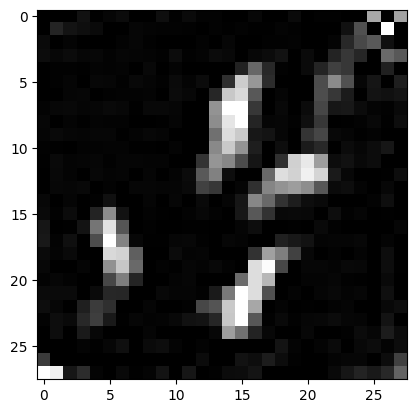

In [11]:
sample_batch_size = 64
num_steps = 500
sampler = Euler_Maruyama_sampler  # Euler-Maruyama sampler 사용
samples = sampler(score_model, marginal_prob_std_fn,
                  diffusion_coeff_fn, sample_batch_size,
                  num_steps=num_steps, device=device, y=None)
samples = samples.clamp(0.0, 1.0)

plt.imshow(samples[0].cpu().detach().permute(1,2,0),cmap='gray')

# 텍스트 입력하여 이미지가 생성되도록 하는 어텐션 레이어 추가

+ 어텐선 모듈
어텐션 모델은 QKV(Query, Key, Value)벡터로 학습 -> KV에 대한 질의 Q에 대한 스코어 계산
Q와 KV의 유사도 계산한 벡터간 거리가 가까워지는 방향으로 학습 모델 설계
Q가 MNIST 숫자


<img src='./modify/6.png'>


+ 트랜스포머 모듈

교차 어텐션, 피드 포워드 신경망을 통합

+ 교차 어텐션

서로 다른 두개의 시퀀스를 다루는 어텐션 모듈


차원 형태는 [배치, 시퀀스 길이, 은닉 차원]인 입력텐서와와 [배치, 컨텍스트 시퀀스 길이, 컨텍스트 차원]인 컨텍스트 텐서 사용

In [40]:
class CrossAttention(nn.Module):
    def __init__(self,embed_dim,hidden_dim,context_dim=None, num_heads=1): #임베딩 차원, 은닉차원, 컨텍스트 차원(self attention이면 None), 어텐션 헤드 수
        super(CrossAttention,self).__init__()

        self.hidden_dim=hidden_dim
        self.context_dim=context_dim
        self.embed_dim=embed_dim

        self.query=nn.Linear(hidden_dim,embed_dim,bias=False)# 쿼리에 대한 학습
        if context_dim is None:
            self.self_attn=True
            self.key=nn.Linear(hidden_dim,embed_dim,bias=False)
            self.value=nn.Linear(hidden_dim,hidden_dim,bias=False)

        else:
            self.self_attn=False
            self.key=nn.Linear(context_dim,embed_dim,bias=False)
            self.value=nn.Linear(context_dim,hidden_dim,bias=False)

    def forward(self,tokens,context=None): # 토큰들[배치, 시퀀스크기, 은닉차원], 컨텍스트 정보[배치, 컨텍스트 시퀀스 크기, 컨텍스트 차원]
        if self.self_attn: # self-attention
            Q=self.query(tokens)
            K=self.key(tokens)
            V=self.value(tokens)
        else:
            Q=self.query(tokens)
            K=self.key(context)
            V=self.value(context)

        
        # Compute score matrices, attention matrices, context vectors
        scoremats=torch.einsum("BTH,BSH->BTS", Q, K)  # Q, K간 내적 계산. 스코어 행렬 획득
        """    
            Q: torch.Size([1024, 25, 128])
            K: torch.Size([1024, 25, 128])
            scoremats: torch.Size([1024, 25, 25])
        """

        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1) # 스코어 행렬의 softmax 계산
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # 어텐션 행렬 적용된 V벡터 계산 
        return ctx_vecs

In [41]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(TransformerBlock, self).__init__()

        self.attn_self=CrossAttention(hidden_dim,hidden_dim)
        self.attn_cross=CrossAttention(hidden_dim,hidden_dim,context_dim)

        self.norm1=nn.LayerNorm(hidden_dim)
        self.norm2=nn.LayerNorm(hidden_dim)
        self.norm3=nn.LayerNorm(hidden_dim)

        self.ffn=nn.Sequential(
            nn.Linear(hidden_dim,3*hidden_dim),
            nn.GELU(),
            nn.Linear(3*hidden_dim,hidden_dim)
        ) # 피드 포워드 네트워크 2개의 은닉 레이어구성

    def forward(self,x,context=None):
        x=self.attn_self(self.norm1(x))+x
        x=self.attn_cross(self.norm2(x),context=context)+x
        x=self.ffn(self.norm3(x))+x

        return x

# 공간 트랜스포머 모듈로 앞의 모듈 통합

In [42]:
class SpatialTransformer(nn.Module):
    def __init__(self,hidden_dim,context_dim):
        super(SpatialTransformer,self).__init__()
        self.transformer=TransformerBlock(hidden_dim,context_dim)

    def forward(self,x,context=None): # x: 입력텐서 [배치, 채널, 높이, 너비], context: 컨택스트 텐서[배치, 컨텍스트 시퀀스 크기, 컨텍스트 차원]
        b,c,h,w=x.shape
        x_in=x

        x=rearrange(x, "b c h w -> b (h w) c") # 입력텐서 재배열
        x=self.transformer(x,context)
        x=rearrange(x, "b (h w) c -> b c h w", h=h, w=w)

        return x+x_in

# Unet, 공간 트랜스포머 통합

In [43]:
class Unet_Transformer(nn.Module):
    def __init__(self,marginal_prob_std, channels=[32,64,128,256],embed_dim=256, text_dim=256, nClass=10):
        """
        marginal_prob_std: 시간 t에 대한 표준편차 반환 함수
        channels: 각 해상도의 특징 맵의 채널 수
        embed_dim: 가우시안 랜덤 특징 임베딩 차원
        text_dim: 텍스트/숫자 임베딩 차원
        nClass: 모델링할 클래스 수수
        """
        super().__init__()

        self.time_embed=nn.Sequential( # 시간에 대한 가우시안 랜덤 특징 임베딩 계층
            GaussianFourierPorjection(embed_dim=embed_dim),
            nn.Linear(embed_dim,embed_dim)
        )

        # 인코딩 레이어 구현
        self.conv1=nn.Conv2d(1,channels[0],kernel_size=3,stride=1,bias=False)# mnist여서 1채널
        self.dense1=Dense(embed_dim,channels[0])
        self.gnorm1=nn.GroupNorm(4,num_channels=channels[0]) # 그룹 정규화
        self.conv2=nn.Conv2d(channels[0],channels[1],kernel_size=3,stride=2,bias=False)
        self.dense2=Dense(embed_dim,channels[1])
        self.gnorm2=nn.GroupNorm(32,num_channels=channels[1])

        self.conv3=nn.Conv2d(channels[1],channels[2],kernel_size=3,stride=2,bias=False)
        self.dense3=Dense(embed_dim,channels[2])
        self.gnorm3=nn.GroupNorm(32,channels[2])
        # 공간트랜스포머 추가
        self.attn3=SpatialTransformer(channels[2],text_dim) # 컨텍스트 정보, 텍스트 임베딩 차원을 공간 트랜스포머에 설정정

        self.conv4=nn.Conv2d(channels[2],channels[3],kernel_size=3,stride=2,bias=False)
        self.dense4=Dense(embed_dim,channels[3])
        self.gnorm4=nn.GroupNorm(32,num_channels=channels[3])
        self.attn4=SpatialTransformer(channels[3],text_dim)

        # 디코딩 레이어 구현(해상도 증가)
        self.tconv4=nn.ConvTranspose2d(channels[3],channels[2],kernel_size=3,stride=2,bias=False)
        self.dense5=Dense(embed_dim,channels[2])
        self.tgnorm4=nn.GroupNorm(32,channels[2])
        self.tconv3=nn.ConvTranspose2d(channels[2], channels[1],kernel_size=3,stride=2,bias=False,output_padding=1)
        self.dense6=Dense(embed_dim,channels[1])
        self.tgnorm3=nn.GroupNorm(32,channels[1])

        self.tconv2=nn.ConvTranspose2d(channels[1],channels[0],kernel_size=3,stride=2,bias=False,output_padding=1)
        self.dense7=Dense(embed_dim,channels[0])
        self.tgnorm2=nn.GroupNorm(32,channels[0])
        self.tconv1=nn.ConvTranspose2d(channels[0],1,kernel_size=3,stride=1)

        # 스위시 활성화 함수
        self.act=lambda x:x*torch.sigmoid(x) # nn.SiLU()
        self.marginal_prob_std=marginal_prob_std
        self.cond_embed=nn.Embedding(nClass,text_dim)

    def forward(self,x,t,y=None):
        """
        x는 입력텐서
        t는 시간 텐서
        y는 타겟 텐서
        h는 U-net을 통과한 출력텐서서
        """
        embed=self.act(self.time_embed(t))
        y_embed=self.cond_embed(y).unsqueeze(1)
        

        #인코딩
        h1=self.conv1(x)+self.dense1(embed)
        h1=self.act(self.gnorm1(h1))

        h2=self.conv2(h1)+self.dense2(embed)
        h2=self.act(self.gnorm2(h2))

        h3=self.conv3(h2)+self.dense3(embed)
        h3=self.act(self.gnorm3(h3))
        h3=self.attn3(h3,y_embed)

        h4=self.conv4(h3)+self.dense4(embed)
        h4=self.act(self.gnorm4(h4))
        h4=self.attn4(h4,y_embed)

        # 디코딩딩
        h=self.tconv4(h4)
        h+=self.dense5(embed)
        h=self.act(self.tgnorm4(h))

        h=self.tconv3(h+h3)
        h+=self.dense6(embed)
        h=self.act(self.tgnorm3(h))

        h=self.tconv2(h+h2)
        h+=self.dense7(embed)
        h=self.act(self.tgnorm2(h))

        h=self.tconv1(h+h1)

        h=h/self.marginal_prob_std(t)[:,None,None,None]

        return h



# Stable diffusion 손실 함수 정의

In [44]:
def loss_fn_cond(model,x,y,marginal_prob_std,eps=1e-5): #model : 시간 의존된 스코어 기반 모델, x 입력데이터 미니배치, y: 조건 정보(ex.:) 입력 텍스트 숫자), marginal_prob_std: 표준 푠차 반환 함수, eps: 수치 안정성을 위한 허용값
    random_t=torch.rand(x.shape[0],device=x.device)*(1.-eps)+eps
    z=torch.randn_like(x) # 노이즈 생성
    std=marginal_prob_std(random_t) # 랜덤 시간에 따른 표준편차 계산
    perturbed_x=x+z*std[:,None,None,None]

    score=model(perturbed_x,random_t,y) # 모델을 사용해 왜곡된 데이터와 시간에 대한 스코어획득, 트랜스포머 모델에 쿼리 입력을 위한 Y 추가

    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss



# Unet-Transformer 모델 학습

In [45]:
score_model = torch.nn.DataParallel(Unet_Transformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 100   
batch_size = 1024 
lr = 10e-4        

transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to PyTorch tensor
])
dataset = torchvision.datasets.MNIST('../data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(score_model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

for epoch in tqdm(range(0,n_epochs)):
    avg_loss = 0.
    num_items = 0

    for x, y in tqdm(data_loader):
        x = x.to(device)

        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]


    print(f"EPOCH: {epoch}   Average Loss: {avg_loss/num_items:.1e}")

    torch.save(score_model.state_dict(),'./models/MNIST_Unet_Transformer.pt')

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_20672\2281391514.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t=torch.tensor(t,device=device)
  1%|          | 1/100 [00:05<08:20,  5.06s/it]

EPOCH: 0   Average Loss: 7.1e+02


  2%|▏         | 2/100 [00:09<07:52,  4.82s/it]

EPOCH: 1   Average Loss: 2.1e+02


  3%|▎         | 3/100 [00:14<07:37,  4.72s/it]

EPOCH: 2   Average Loss: 1.4e+02


  4%|▍         | 4/100 [00:18<07:28,  4.67s/it]

EPOCH: 3   Average Loss: 1.1e+02


  5%|▌         | 5/100 [00:23<07:27,  4.71s/it]

EPOCH: 4   Average Loss: 8.6e+01


  6%|▌         | 6/100 [00:28<07:20,  4.68s/it]

EPOCH: 5   Average Loss: 7.4e+01


  7%|▋         | 7/100 [00:32<07:13,  4.66s/it]

EPOCH: 6   Average Loss: 6.6e+01


  8%|▊         | 8/100 [00:37<07:07,  4.65s/it]

EPOCH: 7   Average Loss: 5.9e+01


  9%|▉         | 9/100 [00:42<07:04,  4.66s/it]

EPOCH: 8   Average Loss: 5.4e+01


 10%|█         | 10/100 [00:47<07:06,  4.74s/it]

EPOCH: 9   Average Loss: 5.0e+01


 11%|█         | 11/100 [00:52<07:07,  4.80s/it]

EPOCH: 10   Average Loss: 4.7e+01


 12%|█▏        | 12/100 [00:57<07:05,  4.83s/it]

EPOCH: 11   Average Loss: 4.5e+01


 13%|█▎        | 13/100 [01:01<07:01,  4.84s/it]

EPOCH: 12   Average Loss: 4.3e+01


 14%|█▍        | 14/100 [01:06<06:59,  4.88s/it]

EPOCH: 13   Average Loss: 4.1e+01


 15%|█▌        | 15/100 [01:11<06:50,  4.83s/it]

EPOCH: 14   Average Loss: 3.9e+01


 16%|█▌        | 16/100 [01:16<06:42,  4.79s/it]

EPOCH: 15   Average Loss: 3.8e+01


 17%|█▋        | 17/100 [01:20<06:35,  4.76s/it]

EPOCH: 16   Average Loss: 3.7e+01


 18%|█▊        | 18/100 [01:25<06:28,  4.74s/it]

EPOCH: 17   Average Loss: 3.6e+01


 19%|█▉        | 19/100 [01:30<06:29,  4.81s/it]

EPOCH: 18   Average Loss: 3.6e+01


 20%|██        | 20/100 [01:35<06:32,  4.90s/it]

EPOCH: 19   Average Loss: 3.5e+01


 21%|██        | 21/100 [01:40<06:27,  4.90s/it]

EPOCH: 20   Average Loss: 3.4e+01


 22%|██▏       | 22/100 [01:45<06:20,  4.88s/it]

EPOCH: 21   Average Loss: 3.4e+01


 23%|██▎       | 23/100 [01:50<06:16,  4.89s/it]

EPOCH: 22   Average Loss: 3.2e+01


 24%|██▍       | 24/100 [01:55<06:14,  4.93s/it]

EPOCH: 23   Average Loss: 3.2e+01


 25%|██▌       | 25/100 [02:00<06:10,  4.93s/it]

EPOCH: 24   Average Loss: 3.2e+01


 26%|██▌       | 26/100 [02:05<06:06,  4.95s/it]

EPOCH: 25   Average Loss: 3.1e+01


 27%|██▋       | 27/100 [02:09<05:55,  4.87s/it]

EPOCH: 26   Average Loss: 3.1e+01


 28%|██▊       | 28/100 [02:14<05:46,  4.81s/it]

EPOCH: 27   Average Loss: 3.0e+01


 29%|██▉       | 29/100 [02:19<05:41,  4.81s/it]

EPOCH: 28   Average Loss: 3.0e+01


 30%|███       | 30/100 [02:24<05:33,  4.77s/it]

EPOCH: 29   Average Loss: 3.0e+01


 31%|███       | 31/100 [02:28<05:28,  4.75s/it]

EPOCH: 30   Average Loss: 2.9e+01


 32%|███▏      | 32/100 [02:33<05:22,  4.74s/it]

EPOCH: 31   Average Loss: 2.9e+01


 33%|███▎      | 33/100 [02:38<05:25,  4.87s/it]

EPOCH: 32   Average Loss: 2.9e+01


 34%|███▍      | 34/100 [02:43<05:17,  4.81s/it]

EPOCH: 33   Average Loss: 2.8e+01


 35%|███▌      | 35/100 [02:48<05:11,  4.79s/it]

EPOCH: 34   Average Loss: 2.8e+01


 36%|███▌      | 36/100 [02:52<05:07,  4.80s/it]

EPOCH: 35   Average Loss: 2.8e+01


 37%|███▋      | 37/100 [02:57<05:01,  4.79s/it]

EPOCH: 36   Average Loss: 2.8e+01


 38%|███▊      | 38/100 [03:02<05:01,  4.86s/it]

EPOCH: 37   Average Loss: 2.7e+01


 39%|███▉      | 39/100 [03:08<05:06,  5.03s/it]

EPOCH: 38   Average Loss: 2.7e+01


 40%|████      | 40/100 [03:12<04:55,  4.93s/it]

EPOCH: 39   Average Loss: 2.7e+01


 41%|████      | 41/100 [03:17<04:46,  4.86s/it]

EPOCH: 40   Average Loss: 2.6e+01


 42%|████▏     | 42/100 [03:22<04:42,  4.87s/it]

EPOCH: 41   Average Loss: 2.6e+01


 43%|████▎     | 43/100 [03:27<04:34,  4.81s/it]

EPOCH: 42   Average Loss: 2.6e+01


 44%|████▍     | 44/100 [03:31<04:27,  4.78s/it]

EPOCH: 43   Average Loss: 2.6e+01


 45%|████▌     | 45/100 [03:36<04:22,  4.78s/it]

EPOCH: 44   Average Loss: 2.6e+01


 46%|████▌     | 46/100 [03:41<04:20,  4.81s/it]

EPOCH: 45   Average Loss: 2.6e+01


 47%|████▋     | 47/100 [03:46<04:13,  4.79s/it]

EPOCH: 46   Average Loss: 2.5e+01


 48%|████▊     | 48/100 [03:50<04:07,  4.76s/it]

EPOCH: 47   Average Loss: 2.5e+01


 49%|████▉     | 49/100 [03:55<04:02,  4.76s/it]

EPOCH: 48   Average Loss: 2.5e+01


 50%|█████     | 50/100 [04:00<03:56,  4.73s/it]

EPOCH: 49   Average Loss: 2.5e+01


 51%|█████     | 51/100 [04:05<03:55,  4.80s/it]

EPOCH: 50   Average Loss: 2.5e+01


 52%|█████▏    | 52/100 [04:10<03:49,  4.78s/it]

EPOCH: 51   Average Loss: 2.4e+01


 53%|█████▎    | 53/100 [04:14<03:44,  4.78s/it]

EPOCH: 52   Average Loss: 2.4e+01


 54%|█████▍    | 54/100 [04:19<03:38,  4.75s/it]

EPOCH: 53   Average Loss: 2.4e+01


 55%|█████▌    | 55/100 [04:24<03:35,  4.79s/it]

EPOCH: 54   Average Loss: 2.4e+01


 56%|█████▌    | 56/100 [04:29<03:30,  4.78s/it]

EPOCH: 55   Average Loss: 2.4e+01


 57%|█████▋    | 57/100 [04:34<03:26,  4.80s/it]

EPOCH: 56   Average Loss: 2.4e+01


 58%|█████▊    | 58/100 [04:38<03:21,  4.81s/it]

EPOCH: 57   Average Loss: 2.4e+01


 59%|█████▉    | 59/100 [04:43<03:19,  4.87s/it]

EPOCH: 58   Average Loss: 2.4e+01


 60%|██████    | 60/100 [04:48<03:14,  4.86s/it]

EPOCH: 59   Average Loss: 2.4e+01


 61%|██████    | 61/100 [04:53<03:09,  4.87s/it]

EPOCH: 60   Average Loss: 2.3e+01


 62%|██████▏   | 62/100 [04:58<03:03,  4.83s/it]

EPOCH: 61   Average Loss: 2.3e+01


 63%|██████▎   | 63/100 [05:03<02:57,  4.80s/it]

EPOCH: 62   Average Loss: 2.3e+01


 64%|██████▍   | 64/100 [05:07<02:52,  4.79s/it]

EPOCH: 63   Average Loss: 2.3e+01


 65%|██████▌   | 65/100 [05:12<02:46,  4.74s/it]

EPOCH: 64   Average Loss: 2.3e+01


 66%|██████▌   | 66/100 [05:17<02:40,  4.71s/it]

EPOCH: 65   Average Loss: 2.3e+01


 67%|██████▋   | 67/100 [05:21<02:34,  4.67s/it]

EPOCH: 66   Average Loss: 2.3e+01


 68%|██████▊   | 68/100 [05:26<02:28,  4.65s/it]

EPOCH: 67   Average Loss: 2.3e+01


 69%|██████▉   | 69/100 [05:30<02:24,  4.66s/it]

EPOCH: 68   Average Loss: 2.3e+01


 70%|███████   | 70/100 [05:35<02:19,  4.64s/it]

EPOCH: 69   Average Loss: 2.3e+01


 71%|███████   | 71/100 [05:40<02:14,  4.64s/it]

EPOCH: 70   Average Loss: 2.3e+01


 72%|███████▏  | 72/100 [05:44<02:10,  4.64s/it]

EPOCH: 71   Average Loss: 2.3e+01


 73%|███████▎  | 73/100 [05:49<02:06,  4.69s/it]

EPOCH: 72   Average Loss: 2.3e+01


 74%|███████▍  | 74/100 [05:54<02:01,  4.68s/it]

EPOCH: 73   Average Loss: 2.2e+01


 75%|███████▌  | 75/100 [05:58<01:56,  4.67s/it]

EPOCH: 74   Average Loss: 2.2e+01


 76%|███████▌  | 76/100 [06:03<01:51,  4.66s/it]

EPOCH: 75   Average Loss: 2.2e+01


 77%|███████▋  | 77/100 [06:08<01:47,  4.68s/it]

EPOCH: 76   Average Loss: 2.2e+01


 78%|███████▊  | 78/100 [06:12<01:42,  4.65s/it]

EPOCH: 77   Average Loss: 2.2e+01


 79%|███████▉  | 79/100 [06:17<01:37,  4.63s/it]

EPOCH: 78   Average Loss: 2.2e+01


 80%|████████  | 80/100 [06:22<01:33,  4.66s/it]

EPOCH: 79   Average Loss: 2.2e+01


 81%|████████  | 81/100 [06:27<01:29,  4.74s/it]

EPOCH: 80   Average Loss: 2.2e+01


 82%|████████▏ | 82/100 [06:31<01:24,  4.71s/it]

EPOCH: 81   Average Loss: 2.2e+01


 83%|████████▎ | 83/100 [06:36<01:19,  4.69s/it]

EPOCH: 82   Average Loss: 2.2e+01


 84%|████████▍ | 84/100 [06:41<01:14,  4.68s/it]

EPOCH: 83   Average Loss: 2.2e+01


 85%|████████▌ | 85/100 [06:45<01:10,  4.71s/it]

EPOCH: 84   Average Loss: 2.2e+01


 86%|████████▌ | 86/100 [06:50<01:05,  4.69s/it]

EPOCH: 85   Average Loss: 2.2e+01


 87%|████████▋ | 87/100 [06:55<01:00,  4.67s/it]

EPOCH: 86   Average Loss: 2.2e+01


 88%|████████▊ | 88/100 [06:59<00:56,  4.70s/it]

EPOCH: 87   Average Loss: 2.2e+01


 89%|████████▉ | 89/100 [07:04<00:52,  4.74s/it]

EPOCH: 88   Average Loss: 2.2e+01


 90%|█████████ | 90/100 [07:09<00:47,  4.71s/it]

EPOCH: 89   Average Loss: 2.2e+01


 91%|█████████ | 91/100 [07:13<00:42,  4.68s/it]

EPOCH: 90   Average Loss: 2.2e+01


 92%|█████████▏| 92/100 [07:18<00:37,  4.67s/it]

EPOCH: 91   Average Loss: 2.1e+01


 93%|█████████▎| 93/100 [07:23<00:33,  4.73s/it]

EPOCH: 92   Average Loss: 2.1e+01


 94%|█████████▍| 94/100 [07:28<00:28,  4.72s/it]

EPOCH: 93   Average Loss: 2.2e+01


 95%|█████████▌| 95/100 [07:32<00:23,  4.69s/it]

EPOCH: 94   Average Loss: 2.1e+01


 96%|█████████▌| 96/100 [07:37<00:18,  4.67s/it]

EPOCH: 95   Average Loss: 2.1e+01


 97%|█████████▋| 97/100 [07:42<00:14,  4.74s/it]

EPOCH: 96   Average Loss: 2.1e+01


 98%|█████████▊| 98/100 [07:46<00:09,  4.72s/it]

EPOCH: 97   Average Loss: 2.1e+01


 99%|█████████▉| 99/100 [07:51<00:04,  4.70s/it]

EPOCH: 98   Average Loss: 2.1e+01


100%|██████████| 100/100 [07:56<00:00,  4.76s/it]

EPOCH: 99   Average Loss: 2.1e+01
